### Focus on Swiss Stocks:
- ABB (ABBN)
- Credit Suisse (CSGN)
- Nestle (NESN)
- Novartis (NOVN)

### The next goals are:
- Exploratory data analysis and stylized facts
- clean covariance matrices
- rolling window
- forecast LSTM


#### Stylized facts:
- Absence of linear autocorrelation
- Heavy-tailed returns
- Long memory of volatility
- outliers (threshold)

#### Plots:
- r_t vs time
- C (tao)
- log P>(r) vs r, if the tail is convex, P>(r) is heavy-tailed (1-ECDF(x)=RECDF(x)= P>(x) --> statsmodel)
- q-q plot of r vs Gaussian and exponential distribution
- plot C_|r|(tao) with log-log axes

 Implement a function that takes as input price returns and outputs the power-law exponent, 
 the starting point, the likelihood ratio of power-law vs exponential and power-law vs log-normal, 
 and if at all possible creates a pdf plot.

#### Correlation matrix cleaning

- We have very small N...
- rolling window length T
- clip eigenvalues


#### Strategies

- What exactly? 
- Measuring device


# Financial Big Data - Final Project

In [473]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lib_preprocessing import preprocess

%matplotlib inline

## 1 Data preprocessing

In [9]:
DATA_RAW_DIR = './data/Raw/'
DATA_CLEAN_DIR = './data/Clean/'

stocks_s = ['ABBN.S', 'CSGN.S', 'NESN.S', 'NOVN.S']
cleaned_df_s = preprocess(stocks_s, DATA_RAW_DIR, verbosity=1)

Processed stock ABBN.S
Processed stock CSGN.S
Processed stock NESN.S
Processed stock NOVN.S


In [10]:
stocks_vx = ['ABBN.VX', 'CSGN.VX', 'NESN.VX', 'NOVN.VX']
cleaned_df_vx = preprocess(stocks_vx, DATA_RAW_DIR, verbosity=1)

/Users/roman/Documents/Uni/Semester 9 - EPFL/Financial Big Data/Fin-525/lib_preprocessing.py:80: RuntimeWarning: divide by zero encountered in log
  df['bid-ask'] = np.log(df['bid-ask']).diff()
/Users/roman/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/core/algorithms.py:1823: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


Processed stock ABBN.VX
Processed stock CSGN.VX
Processed stock NESN.VX
Processed stock NOVN.VX


In [11]:
# Saving ABBN.S, CSGN.S, NESN.S, NOVN.S (ACNN S) as compressed CSV
cleaned_df_s.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_s.csv.gz'), compression='gzip')

# Saving ABBN.VX, CSGN.VX, NESN.VX, NOVN.VX (ACNN VX) as compressed CSV
cleaned_df_vx.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_vx.csv.gz'), compression='gzip')

In [18]:
stocks = ['ABBN', 'CSGN', 'NESN', 'NOVN']
cleaned_df_s.columns = stocks
cleaned_df_vx.columns = stocks

In [87]:
cleaned_df = pd.concat([cleaned_df_vx, cleaned_df_s])

# Saving ABBN, CSGN, NESN, NOVN (ACNN) as compressed CSV
cleaned_df.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn.csv.gz'), compression='gzip')

In [474]:
# Loading the cleaned dataset
cleaned_df = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'acnn.csv.gz'), compression='gzip', index_col='datetime', parse_dates=True)

In [483]:
df_sign = np.sign(cleaned_df.dropna())

In [484]:
missing_hours_per_day = 5 - df_sign.groupby(lambda x: x.date).apply(lambda x: len(x))
np.histogram(missing_hours_per_day, bins=4)

(array([3374,    3,    2,    5]), array([0., 1., 2., 3., 4.]))

In [486]:
missing_hours_per_day_df = pd.DataFrame(missing_hours_per_day)
missing_hours_per_day_df.index = pd.to_datetime(missing_hours_per_day_df.index)
missing_hours_per_day_df.columns = ['missing_hours']
missing_hours_per_day_df = missing_hours_per_day_df.resample('1H').pad()
df_sign_missing = df_sign.join(missing_hours_per_day_df,how='inner')

df_sign_missing = df_sign_missing[df_sign_missing.missing_hours == 0]

df_sign = df_sign_missing.drop('missing_hours', axis=1)

In [487]:
df_sign.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_sign.csv.gz'), compression='gzip')

## 2 Stylized facts

In [108]:
def plot_stocks(df, title=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    df['ABBN'].plot(ax=ax[0,0])
    df['CSGN'].plot(ax=ax[0,1])
    df['NESN'].plot(ax=ax[1,0])
    df['NOVN'].plot(ax=ax[1,1])
    if title is not None:
        fig.suptitle(title, fontsize=16)
    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132ad25c0>,
      dtype=object)

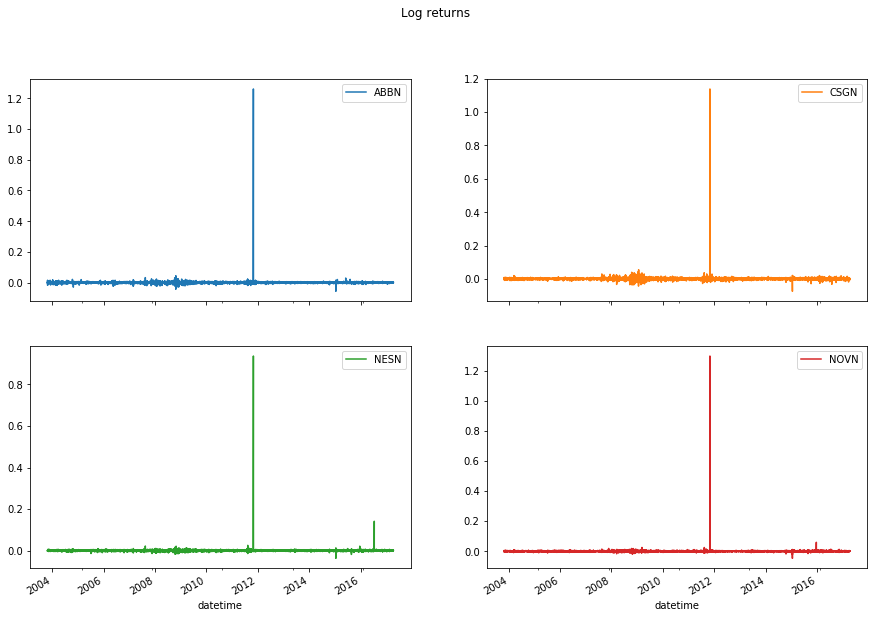

In [146]:
cleaned_df.plot(subplots=True, layout=(2,2), figsize=(15,10), title='Log returns')

In [147]:
cleaned_df = cleaned_df[cleaned_df < 0.3].dropna()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ad7da20>,
      dtype=object)

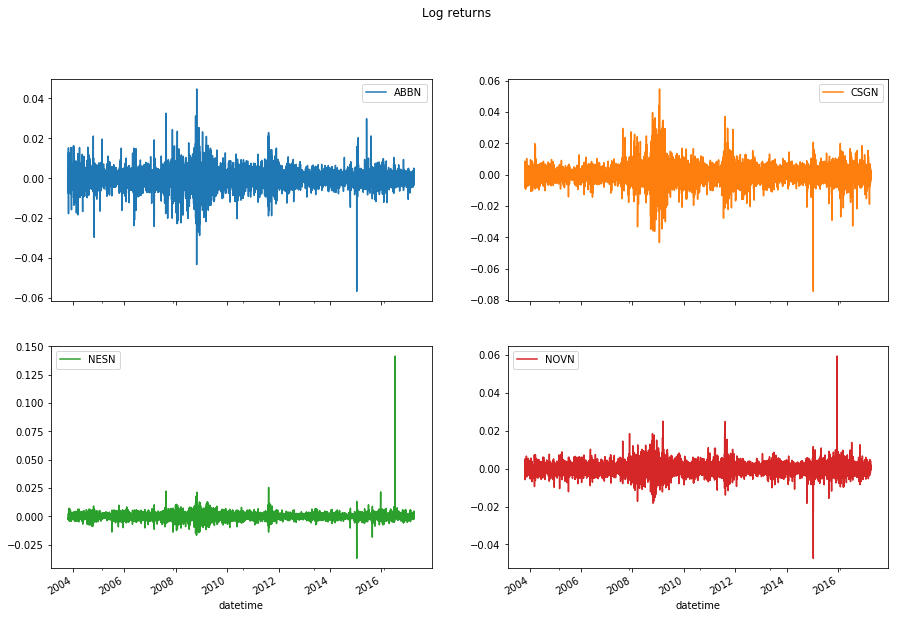

In [148]:
cleaned_df.plot(subplots=True, layout=(2,2), figsize=(15,10), title='Log returns')

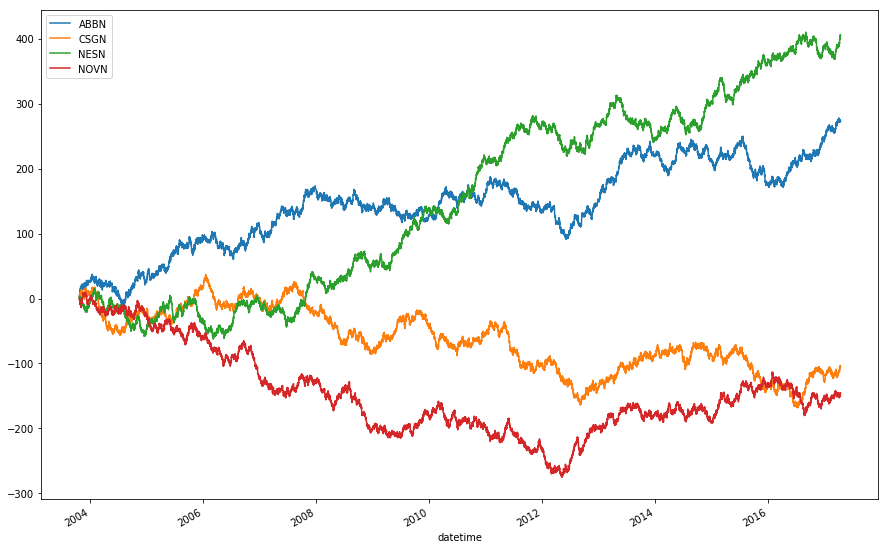

In [149]:
np.sign(cleaned_df).cumsum().plot(figsize=(15,10))

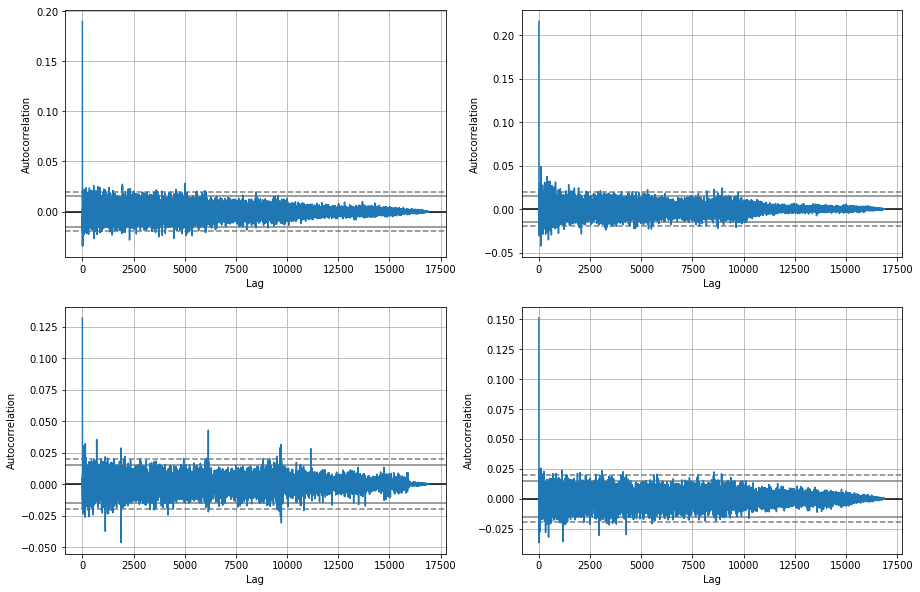

In [150]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
pd.plotting.autocorrelation_plot(cleaned_df['ABBN'], ax=ax[0,0])
pd.plotting.autocorrelation_plot(cleaned_df['CSGN'], ax=ax[0,1])
pd.plotting.autocorrelation_plot(cleaned_df['NESN'], ax=ax[1,0])
pd.plotting.autocorrelation_plot(cleaned_df['NOVN'], ax=ax[1,1])

In [152]:
from statsmodels.distributions.empirical_distribution import ECDF

In [185]:
def plot_1ecdf(df, stock_name, ax):
    ecdf = ECDF(abs(df[stock_name]))
    ax.plot(ecdf.x[:-1], np.log(1-ecdf.y[:-1]))
    ax.set_xlabel('|r|')
    ax.set_ylabel('log P_>(|r|)')
    ax.set_title('1 - ECDF for {}'.format(stock_name))

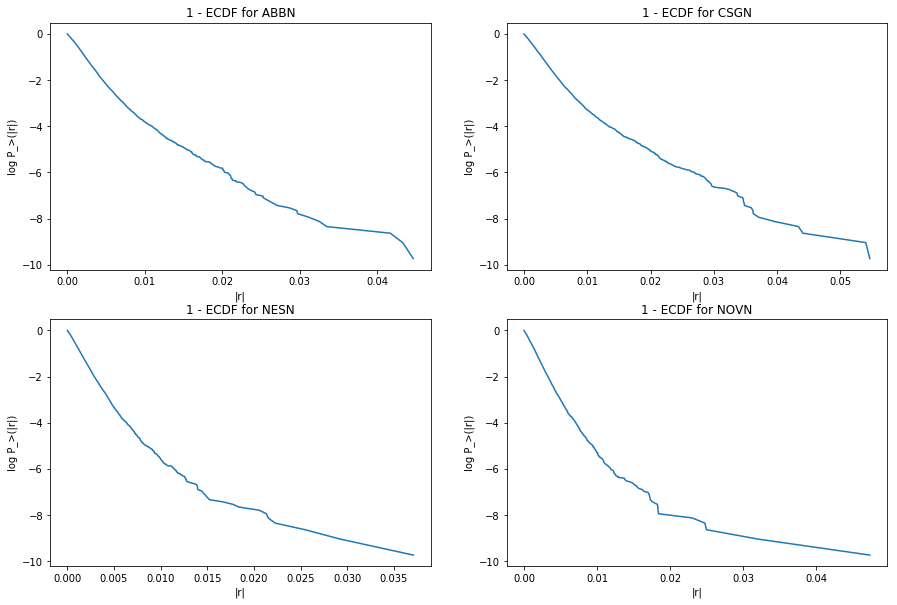

In [186]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plot_1ecdf(cleaned_df, 'ABBN', ax=ax[0,0])
plot_1ecdf(cleaned_df, 'CSGN', ax=ax[0,1])
plot_1ecdf(cleaned_df, 'NESN', ax=ax[1,0])
plot_1ecdf(cleaned_df, 'NOVN', ax=ax[1,1])

## 3 Forecasting

### 3.1 Creating the dataloaders

In [785]:
import torch
from torch.utils.data import Dataset, DataLoader

In [682]:
def return_to_class(ret):
    ''' 0 is class 0, 1 is class 1, -1 is class 2 '''
    if ret == -1:
        return 2
    else:
        return ret
    
def class_to_return(cl):
    if cl == 2:
        return -1
    else:
        return int(cl)

In [749]:
class StockDataSet(Dataset):
    def __init__(self, df, window_size=15, step_size=5):
        self.datetime = df.index
        self.data = []
        
        for stock_name in df.columns:
            for window_start in range(0, len(df) - window_size, step_size):
                w = df[stock_name].iloc[window_start: window_start + window_size]
                self.data.append(w.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise StopIteration
            
        window = self.data[idx]
        series = window[:-1]
        target = window[-1]
        
        return series, target

### 3.2 Forecasting model

In [818]:
class LSTM_Model(torch.nn.Module):
    """
    Creates a LSTM network with a fully connected output layer.
    init_hidden() has to be called for every minibatch to reset the hidden state.

    Args:

        input_size (int): Length of input vector for each time step

        hidden_size (int, optional): Size of hidden LSTM state

        num_layers (int, optional): Number of stacked LSTM modules

        dropout (float, optional): Dropout value to use inside LSTM and between
            LSTM layer and fully connected layer.

    """

    def __init__(self, input_size, hidden_size=128, num_layers=1, dropout=0):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM input dimension is: (batch_size, time_steps, num_features)
        # LSTM output dimension is: (batch_size, time_steps, hidden_size)
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, 1)
        self.tanh = torch.nn.Tanh()

    def forward(self, x, hidden):
        self.lstm.flatten_parameters() # For deep copy
        x = self.lstm(x, hidden)[0][:, -1, :] # Take only last output of LSTM (many-to-one RNN)
        x = x.view(x.shape[0], -1) # Flatten to (batch_size, hidden_size)
        x = self.fc(x)
        x = self.tanh(x)
        return x

    def init_hidden(self, batch_size):
        '''
        Initializing the hidden layer.
        Call every mini-batch, since nn.LSTM does not reset it itself.
        '''
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        if torch.cuda.is_available():
            return (h_0.cuda(), c_0.cuda())
        else:
            return (h_0, c_0)

### 3.3 Training the model

In [890]:
window_size = 5*5
step_size = 1

start_date_train = pd.to_datetime('2013-04-05')
end_date_train = start_date_train + datetime.timedelta(days=150)

In [891]:
batch_size = 32

train_dataset = StockDataSet(df_sign.loc[start_date_train:end_date_train], window_size=window_size, step_size=step_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

In [892]:
model = LSTM_Model(1, hidden_size=128, num_layers=2, dropout=0.2)
criterion = torch.nn.MSELoss() #torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
weight_decay = 1e-3 # L2 regularizer parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

In [893]:
num_epochs = 50

losses = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    epoch_losses = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        hidden = model.init_hidden(batch_size)
        
        # Forward pass
        preds = model(inputs.reshape(batch_size, window_size-1, 1).float(), hidden)

        loss = criterion(preds, labels.reshape(-1,1).float())
        #losses.append(loss.item())
        epoch_losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
    losses.append(np.array(epoch_losses).mean())

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


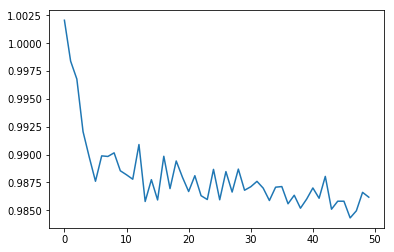

In [894]:
plt.plot(np.arange(num_epochs), losses)

### 3.4 Prediction on test data

In [895]:
test_window = df_sign.loc[end_date_train:].iloc[:window_size-1]

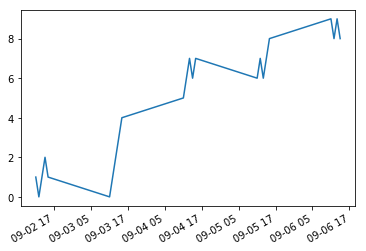

In [896]:
test_window['ABBN'].cumsum().plot()

In [897]:
input_test = test_window['ABBN'].values
input_test = torch.Tensor(input_test).reshape(1,-1,1)
input_test.shape

torch.Size([1, 24, 1])

In [898]:
predictions = []

num_values_to_predict = 25
for i in range(num_values_to_predict):
    hidden = model.init_hidden(len(input_test))
    pred = model(input_test, hidden)
    pred_sign = class_to_return(pred.argmax())
    predictions.append(pred)
    input_test = torch.cat([input_test, torch.Tensor([pred_sign]).reshape(1,1,1).float()], dim=1)[:,1:,:]

In [899]:
predictions

[tensor([[-0.0795]], grad_fn=<TanhBackward>),
 tensor([[-0.0004]], grad_fn=<TanhBackward>),
 tensor([[0.0399]], grad_fn=<TanhBackward>),
 tensor([[0.0316]], grad_fn=<TanhBackward>),
 tensor([[0.0287]], grad_fn=<TanhBackward>),
 tensor([[0.0075]], grad_fn=<TanhBackward>),
 tensor([[0.0133]], grad_fn=<TanhBackward>),
 tensor([[0.0160]], grad_fn=<TanhBackward>),
 tensor([[0.0186]], grad_fn=<TanhBackward>),
 tensor([[0.0081]], grad_fn=<TanhBackward>),
 tensor([[0.0236]], grad_fn=<TanhBackward>),
 tensor([[0.0184]], grad_fn=<TanhBackward>),
 tensor([[0.0167]], grad_fn=<TanhBackward>),
 tensor([[0.0180]], grad_fn=<TanhBackward>),
 tensor([[0.0139]], grad_fn=<TanhBackward>),
 tensor([[0.0140]], grad_fn=<TanhBackward>),
 tensor([[0.0203]], grad_fn=<TanhBackward>),
 tensor([[0.0152]], grad_fn=<TanhBackward>),
 tensor([[0.0225]], grad_fn=<TanhBackward>),
 tensor([[0.0124]], grad_fn=<TanhBackward>),
 tensor([[0.0269]], grad_fn=<TanhBackward>),
 tensor([[0.0130]], grad_fn=<TanhBackward>),
 tensor(

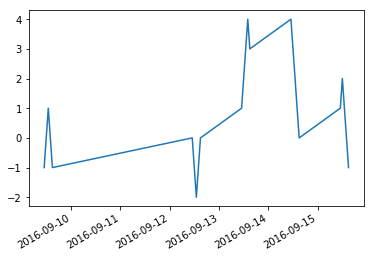

In [884]:
df_sign.loc[end_date_train:].iloc[window_size:window_size+num_values_to_predict]['ABBN'].cumsum().plot()

In [885]:
df_sign.loc[end_date_train:].iloc[window_size:window_size+num_values_to_predict]['ABBN']

2016-09-09 11:00:00   -1.0
2016-09-09 12:00:00    1.0
2016-09-09 13:00:00    1.0
2016-09-09 14:00:00   -1.0
2016-09-09 15:00:00   -1.0
2016-09-12 11:00:00    1.0
2016-09-12 12:00:00   -1.0
2016-09-12 13:00:00   -1.0
2016-09-12 14:00:00    1.0
2016-09-12 15:00:00    1.0
2016-09-13 11:00:00    1.0
2016-09-13 12:00:00    1.0
2016-09-13 13:00:00    1.0
2016-09-13 14:00:00    1.0
2016-09-13 15:00:00   -1.0
2016-09-14 11:00:00    1.0
2016-09-14 12:00:00   -1.0
2016-09-14 13:00:00   -1.0
2016-09-14 14:00:00   -1.0
2016-09-14 15:00:00   -1.0
2016-09-15 11:00:00    1.0
2016-09-15 12:00:00    1.0
2016-09-15 13:00:00   -1.0
2016-09-15 14:00:00   -1.0
2016-09-15 15:00:00   -1.0
Name: ABBN, dtype: float64